## Import Modules and Libraries

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, add, concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


## Import CiFAR Dataset
- It is a more advance dataset compared to MNIST
- It has 10 classes 
- The dimension of the images are 32x32x3 since it is a RGB image
- Shown below are the classses in the CiFAR dataset
- Like MNIST, CiFAR also has 50K training images and labels as well as 10K test images and labels

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


## Print training data dimensions

In [3]:
print(train_features.shape)

(50000, 32, 32, 3)


## Displaying a sample from each class of the dataset

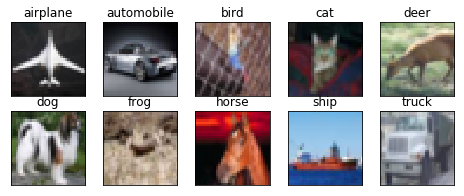

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Function for plotting accuracy and loss during model training

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Accuracy Calculation for a model

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Data Float Conversion , remapping pixel values between 0 & 1, and One-Hot encoding

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Model Architecture and Compiling Model
- This model is built using functional API and not Sequential model
- This model consists of various types of convolutions like Depthwise Separable convolution, Dilated convolution, Spatial Separable convolution, and grouped convolutions

- ### Separable Convolution:
  
  ![](SeparableConv.gif)
  - They are extensively used in Inception and Xception networks
  - Instead of using 3x3, we use 3x1 and then 1x3 over an image
  - This reduces the parameters by around 66%
  - The accuracy drop is around 0.2-0.8%
  
- ### Depthwise Convolution:

  ![](depthwise.gif)
  - We divide the depth i.e. the channels and convolve witht a kernel on each of the channel
  - Then we concaenatet the output and use 1x1 to get the output
  - Huge number of parameters are reduced using depthwise convolution
  - Accuracy drop is around 0.2-0.6 %
  
  
- ### Dilated Convolution

![](dilated.gif)
  - It is mostly used for segmentation network
  - It increases the receptive field of the network

- ### Grouped Convolutions:
  
  ![](grouped.png)
  - Different types of convolutions are used parallely to improve the detection result
  - It is useful to detect objects with different sizes in the network

In [9]:
input = Input(shape=(32, 32, 3,))

# Dropout rate
drop = 0.35

# Convolution Block
layer1 = Convolution2D(32, 3, 3, border_mode='same')(input)                             # Normal Convolution
layer2 = Activation('relu')(layer1)
layer3 = BatchNormalization()(layer2)

layer4a = Convolution2D(64, 3, 1, border_mode='same')(layer3)                           # Separable Convolution                        
layer4b = Convolution2D(64, 1, 3, border_mode='same')(layer4a)
layer5 = Activation('relu')(layer4b)
layer6 = BatchNormalization()(layer5)

layer7 = SeparableConv2D(128, 3, 3, border_mode='same', depth_multiplier = 1)(layer6)   # Depthwise Convolution
layer8 = Activation('relu')(layer7)
layer9 = BatchNormalization()(layer8)

layer10 = Dropout(drop)(layer9)

# Transition Block
layer11 = MaxPooling2D(pool_size=(2, 2))(layer10)                                       
layer12 = Convolution2D(64, 1, 1)(layer11)                                              
layer13 = Activation('relu')(layer12)
layer14 = BatchNormalization()(layer13)

# Convolution Block
layer15 = Convolution2D(64, 3, 3, border_mode='same')(layer14)                          # Normal 3x3
layer16 = Activation('relu')(layer15)
layer17 = BatchNormalization()(layer16)

layer18 = Convolution2D(64, 5, 5, border_mode='same')(layer14)                          # Normal 5x5
layer19 = BatchNormalization()(layer18)
layer20 = Activation('relu')(layer19)

layer21 = concatenate([layer17, layer20])                                               # Concatenation (Grouped Convolution)

layer22 = Dropout(drop)(layer21)

# Transition Block
layer23 = Convolution2D(64, 1, 1)(layer22)                                             
layer24 = Activation('relu')(layer23)
layer25 = BatchNormalization()(layer24)
layer26 = MaxPooling2D(pool_size=(2, 2))(layer25)                                      


# Convolution Block
layer27 = Convolution2D(64, 3, 3, border_mode='same')(layer26)                          # Normal 3x3                    
layer28 = Activation('relu')(layer27)
layer29 = BatchNormalization()(layer28)

layer30 = Convolution2D(64, 3, 3, border_mode='same', dilation_rate = 1)(layer26)       # Dilated convolution with rate=1
layer31 = Activation('relu')(layer30)
layer32 = BatchNormalization()(layer31)

layer33 = Convolution2D(64, 3, 3, border_mode='same', dilation_rate = 2)(layer26)       # Dilated convolution with rate=2
layer34 = Activation('relu')(layer33)
layer35 = BatchNormalization()(layer34)

layer36 = concatenate([layer29, layer32, layer35])                                      # Concatenated for grouped convolution

layer37 = Dropout(drop)(layer36)

# Transition Block
layer38 = Convolution2D(64, 1, 1)(layer37)                                             
layer39 = BatchNormalization()(layer38)
layer40 = Convolution2D(num_classes, 8, 8)(layer39)                                    

# Output Block
layer41 = Flatten()(layer40)                                                           
layer42 = Activation('softmax')(layer41)

model = Model(inputs=[input], outputs=[layer42])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 1), padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 3), padding="same")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(128, (3, 3), depth_multiplier=1, padding="same")`
  app.launch_new_instance()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), dilation_rate=1, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_

## Model Summary

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 32, 32, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 32, 32, 32)   128         activation_2[0][0]               
__________________________________________________________________________________________________
conv2d_3 (

## Training and tracking progress

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 29s 74ms/step - loss: 1.4666 - acc: 0.4974 - val_loss: 1.3348 - val_acc: 0.5426
Epoch 2/50
390/390 [==============================] - 24s 62ms/step - loss: 0.9892 - acc: 0.6566 - val_loss: 1.0144 - val_acc: 0.6557
Epoch 3/50
390/390 [==============================] - 24s 61ms/step - loss: 0.8009 - acc: 0.7208 - val_loss: 1.1581 - val_acc: 0.6487
Epoch 4/50
390/390 [==============================] - 24s 61ms/step - loss: 0.6950 - acc: 0.7589 - val_loss: 0.9178 - val_acc: 0.6993
Epoch 5/50
390/390 [==============================] - 24s 62ms/step - loss: 0.6207 - acc: 0.7820 - val_loss: 0.9982 - val_acc: 0.6913
Epoch 6/50
390/390 [==============================] - 24s 62ms/step - loss: 0.5608 - acc: 0.8030 - val_loss: 0.8445 - val_acc: 0.7262
Epoch 7/50
390/390 [==============================] - 24s 62ms/step - loss: 0.5120 - acc: 0.8214 - val_loss: 0.8093 - val_acc: 0.7526
Epoch 8/50
390/390 [==============================] - 24s 62ms

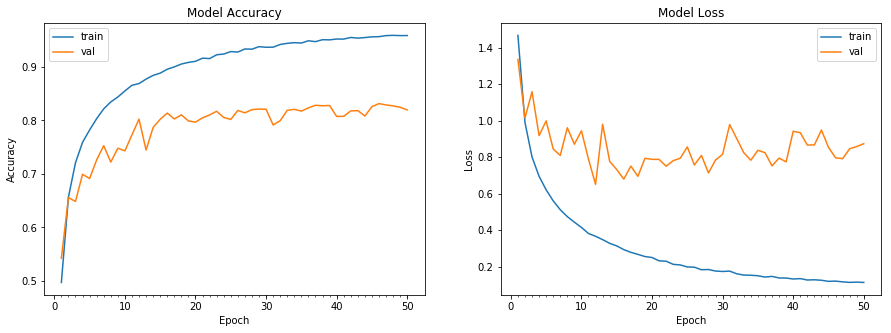

Accuracy on test data is: 81.94


In [11]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

## Spatially Separable Convolution
We use 3x1 and 1x3 convolution to achieve spatially separable convolution. Since, these layers are normal convolution layer with non-square kernel, we can add them in following ways:
1. Continous convolution layers (without BN and ReLU between them)
2. With Batch normalization layer between them
3. With BN and ReLU activation between these two convolution layers

- **Continous Convolutions Layer**  
  Since we consider spatially separable convolution as one type of convolution, we can just add 2 layers with 1x3 and 3x1 without adding any BN layer and ReLU layer. Following are the results without BN and ReLU  
  - Max training accuracy = 95.82%  
  - Max validation accuracy = 83.12%  
  - Epoch Number = 46

- **Convolution Layers with BN layer**  
  With the addition of BatchNormalization layer, we also add few parameters to the network. Following is the performance of the network
  - Max training accuracy = 96.05%  
  - validation accuracy = 82.96%  
  - Epoch nUmber = 46

- **Convolution Layer with BN and Activation layer**  
  - Max training accuracy = 96.21%  
  - validation accuracy = 83.26%  
  - Epoch number = 46 


---

> Following are the training epochs with different layers for spatially separable convolutions 

---

### BN layer in Spatially Separable Convolution:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 1), padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 3), padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(128, (3, 3), depth_multiplier=1, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update

Epoch 1/50
390/390 [==============================] - 28s 72ms/step - loss: 1.4632 - acc: 0.4998 - val_loss: 1.4797 - val_acc: 0.5290
Epoch 2/50
390/390 [==============================] - 25s 65ms/step - loss: 0.9718 - acc: 0.6614 - val_loss: 1.4364 - val_acc: 0.5666
Epoch 3/50
390/390 [==============================] - 25s 65ms/step - loss: 0.7935 - acc: 0.7237 - val_loss: 1.0478 - val_acc: 0.6573
Epoch 4/50
390/390 [==============================] - 25s 65ms/step - loss: 0.6870 - acc: 0.7595 - val_loss: 0.9898 - val_acc: 0.6783
Epoch 5/50
390/390 [==============================] - 25s 65ms/step - loss: 0.6139 - acc: 0.7834 - val_loss: 0.8469 - val_acc: 0.7201
Epoch 6/50
390/390 [==============================] - 25s 65ms/step - loss: 0.5532 - acc: 0.8040 - val_loss: 0.7783 - val_acc: 0.7436
Epoch 7/50
390/390 [==============================] - 25s 65ms/step - loss: 0.5051 - acc: 0.8227 - val_loss: 0.8049 - val_acc: 0.7423
Epoch 8/50
390/390 [==============================] - 25s 65ms

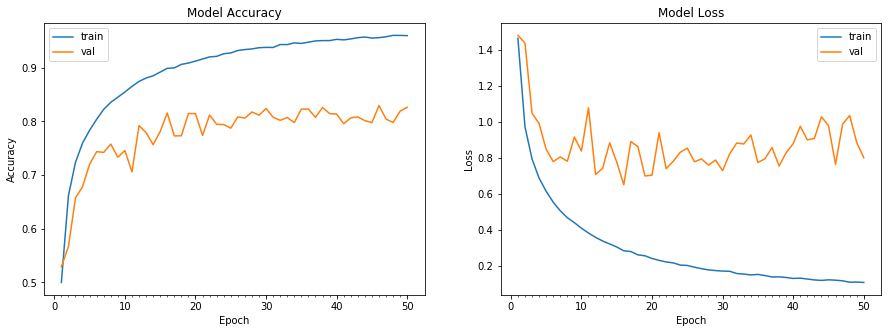

Accuracy on test data is: 82.64


In [12]:
input = Input(shape=(32, 32, 3,))

# Dropout rate
drop = 0.35

# Convolution Block
layer1 = Convolution2D(32, 3, 3, border_mode='same')(input)                             # Normal Convolution
layer2 = Activation('relu')(layer1)
layer3 = BatchNormalization()(layer2)

layer4a = Convolution2D(64, 3, 1, border_mode='same')(layer3)                           # Separable Convolution                        
layer4b = BatchNormalization()(layer4a)
layer4c = Convolution2D(64, 1, 3, border_mode='same')(layer4b)
layer5 = Activation('relu')(layer4c)
layer6 = BatchNormalization()(layer5)

layer7 = SeparableConv2D(128, 3, 3, border_mode='same', depth_multiplier = 1)(layer6)   # Depthwise Convolution
layer8 = Activation('relu')(layer7)
layer9 = BatchNormalization()(layer8)

layer10 = Dropout(drop)(layer9)

# Transition Block
layer11 = MaxPooling2D(pool_size=(2, 2))(layer10)                                       
layer12 = Convolution2D(64, 1, 1)(layer11)                                              
layer13 = Activation('relu')(layer12)
layer14 = BatchNormalization()(layer13)

# Convolution Block
layer15 = Convolution2D(64, 3, 3, border_mode='same')(layer14)                          # Normal 3x3
layer16 = Activation('relu')(layer15)
layer17 = BatchNormalization()(layer16)

layer18 = Convolution2D(64, 5, 5, border_mode='same')(layer14)                          # Normal 5x5
layer19 = BatchNormalization()(layer18)
layer20 = Activation('relu')(layer19)

layer21 = concatenate([layer17, layer20])                                               # Concatenation (Grouped Convolution)

layer22 = Dropout(drop)(layer21)

# Transition Block
layer23 = Convolution2D(64, 1, 1)(layer22)                                             
layer24 = Activation('relu')(layer23)
layer25 = BatchNormalization()(layer24)
layer26 = MaxPooling2D(pool_size=(2, 2))(layer25)                                      


# Convolution Block
layer27 = Convolution2D(64, 3, 3, border_mode='same')(layer26)                          # Normal 3x3                    
layer28 = Activation('relu')(layer27)
layer29 = BatchNormalization()(layer28)

layer30 = Convolution2D(64, 3, 3, border_mode='same', dilation_rate = 1)(layer26)       # Dilated convolution with rate=1
layer31 = Activation('relu')(layer30)
layer32 = BatchNormalization()(layer31)

layer33 = Convolution2D(64, 3, 3, border_mode='same', dilation_rate = 2)(layer26)       # Dilated convolution with rate=2
layer34 = Activation('relu')(layer33)
layer35 = BatchNormalization()(layer34)

layer36 = concatenate([layer29, layer32, layer35])                                      # Concatenated for grouped convolution

layer37 = Dropout(drop)(layer36)

# Transition Block
layer38 = Convolution2D(64, 1, 1)(layer37)                                             
layer39 = BatchNormalization()(layer38)
layer40 = Convolution2D(num_classes, 8, 8)(layer39)                                    

# Output Block
layer41 = Flatten()(layer40)                                                           
layer42 = Activation('softmax')(layer41)

model = Model(inputs=[input], outputs=[layer42])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

---

### Spatially Separable Convolution with BN and activation layer

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 1), padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(128, (3, 3), depth_multiplier=1, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` 

Epoch 1/50
390/390 [==============================] - 29s 74ms/step - loss: 1.5170 - acc: 0.4846 - val_loss: 1.2933 - val_acc: 0.5674
Epoch 2/50
390/390 [==============================] - 26s 66ms/step - loss: 1.0011 - acc: 0.6537 - val_loss: 0.9421 - val_acc: 0.6822
Epoch 3/50
390/390 [==============================] - 26s 65ms/step - loss: 0.8075 - acc: 0.7176 - val_loss: 1.0265 - val_acc: 0.6659
Epoch 4/50
390/390 [==============================] - 25s 65ms/step - loss: 0.6979 - acc: 0.7558 - val_loss: 0.8799 - val_acc: 0.7149
Epoch 5/50
390/390 [==============================] - 26s 65ms/step - loss: 0.6271 - acc: 0.7789 - val_loss: 0.7872 - val_acc: 0.7399
Epoch 6/50
390/390 [==============================] - 26s 65ms/step - loss: 0.5651 - acc: 0.8012 - val_loss: 0.7859 - val_acc: 0.7507
Epoch 7/50
390/390 [==============================] - 26s 66ms/step - loss: 0.5154 - acc: 0.8200 - val_loss: 0.8694 - val_acc: 0.7305
Epoch 8/50
390/390 [==============================] - 26s 65ms

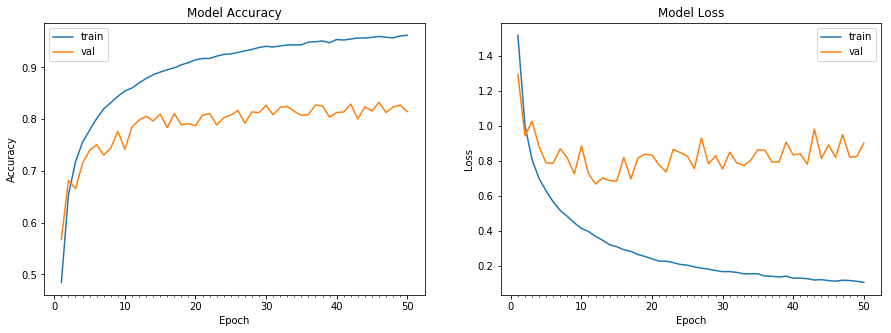

Accuracy on test data is: 81.47


In [13]:
input = Input(shape=(32, 32, 3,))

# Dropout rate
drop = 0.35

# Convolution Block
layer1 = Convolution2D(32, 3, 3, border_mode='same')(input)                             # Normal Convolution
layer2 = Activation('relu')(layer1)
layer3 = BatchNormalization()(layer2)

layer4a = Convolution2D(64, 3, 1, border_mode='same')(layer3)                           # Separable Convolution                        
layer4a_ = Activation('relu')(layer4a)
layer4b = BatchNormalization()(layer4a_)
layer4c = Convolution2D(64, 1, 3, border_mode='same')(layer4b)
layer5 = Activation('relu')(layer4c)
layer6 = BatchNormalization()(layer5)

layer7 = SeparableConv2D(128, 3, 3, border_mode='same', depth_multiplier = 1)(layer6)   # Depthwise Convolution
layer8 = Activation('relu')(layer7)
layer9 = BatchNormalization()(layer8)

layer10 = Dropout(drop)(layer9)

# Transition Block
layer11 = MaxPooling2D(pool_size=(2, 2))(layer10)                                       
layer12 = Convolution2D(64, 1, 1)(layer11)                                              
layer13 = Activation('relu')(layer12)
layer14 = BatchNormalization()(layer13)

# Convolution Block
layer15 = Convolution2D(64, 3, 3, border_mode='same')(layer14)                          # Normal 3x3
layer16 = Activation('relu')(layer15)
layer17 = BatchNormalization()(layer16)

layer18 = Convolution2D(64, 5, 5, border_mode='same')(layer14)                          # Normal 5x5
layer19 = BatchNormalization()(layer18)
layer20 = Activation('relu')(layer19)

layer21 = concatenate([layer17, layer20])                                               # Concatenation (Grouped Convolution)

layer22 = Dropout(drop)(layer21)

# Transition Block
layer23 = Convolution2D(64, 1, 1)(layer22)                                             
layer24 = Activation('relu')(layer23)
layer25 = BatchNormalization()(layer24)
layer26 = MaxPooling2D(pool_size=(2, 2))(layer25)                                      


# Convolution Block
layer27 = Convolution2D(64, 3, 3, border_mode='same')(layer26)                          # Normal 3x3                    
layer28 = Activation('relu')(layer27)
layer29 = BatchNormalization()(layer28)

layer30 = Convolution2D(64, 3, 3, border_mode='same', dilation_rate = 1)(layer26)       # Dilated convolution with rate=1
layer31 = Activation('relu')(layer30)
layer32 = BatchNormalization()(layer31)

layer33 = Convolution2D(64, 3, 3, border_mode='same', dilation_rate = 2)(layer26)       # Dilated convolution with rate=2
layer34 = Activation('relu')(layer33)
layer35 = BatchNormalization()(layer34)

layer36 = concatenate([layer29, layer32, layer35])                                      # Concatenated for grouped convolution

layer37 = Dropout(drop)(layer36)

# Transition Block
layer38 = Convolution2D(64, 1, 1)(layer37)                                             
layer39 = BatchNormalization()(layer38)
layer40 = Convolution2D(num_classes, 8, 8)(layer39)                                    

# Output Block
layer41 = Flatten()(layer40)                                                           
layer42 = Activation('softmax')(layer41)

model = Model(inputs=[input], outputs=[layer42])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

### Spatially Separable Convolution:
- With the addition of BN and ReLU between the two convolution layers of spatially separable convolution, we get improved accuracy but at the same time number of parameters are also increased.
- Since spatially separable convolution are used to reduce the number of parameters in a network, using BN and ReLU completely depends upon the constraints of the network.